In [51]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-06-10,26481.761719,26531.044922,25501.835938,25851.240234,25851.240234,19872933189
2023-06-11,25854.031250,26203.439453,25668.986328,25940.167969,25940.167969,10732609603
2023-06-12,25934.285156,26087.919922,25675.197266,25902.500000,25902.500000,11677889997


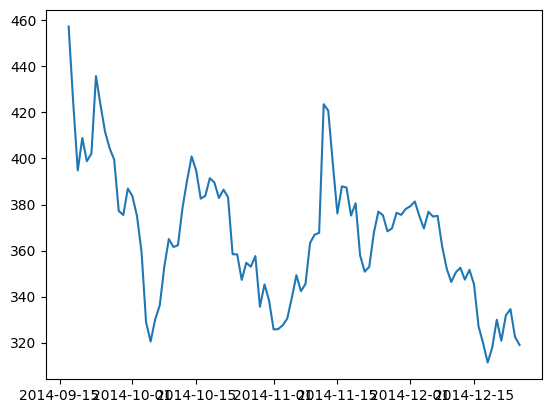

In [52]:
import matplotlib.pyplot as plt
df = data[0:100]
plt.plot(df.index, df.Close)
plt.show()

In [54]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'))

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

In [109]:
# Previous and Next data chaining
# df.Low.rolling(5).min()
#df.Low.rolling(5, center=True).min()  # fractal бодохын тулд өмнөх утгуудыг агуулсан хэсгээс бодно

supports = df[df.Low == df.Low.rolling(5, center=True).min()].Low
resistances = df[df.High == df.High.rolling(5, center=True).max()].High
# merge them into one list
levels = pd.concat([supports, resistances])
levels


Date
2014-09-19    384.532013
2014-09-29    372.239990
2014-10-05    289.295990
2014-10-16    373.070007
2014-10-20    378.252014
2014-10-25    342.877014
2014-11-02    320.626007
2014-11-15    371.007996
2014-11-21    344.112000
2014-11-28    358.454987
2014-12-05    365.756012
2014-12-11    338.763000
2014-12-18    304.231995
2014-09-23    441.557007
2014-10-01    391.378998
2014-10-09    382.726013
2014-10-14    411.697998
2014-10-28    359.984009
2014-11-06    352.966003
2014-11-13    457.092987
2014-11-17    410.199005
2014-11-25    394.700989
2014-11-29    387.601013
2014-12-02    384.037994
2014-12-14    353.316010
2014-12-23    336.286987
dtype: float64

In [93]:
# level diffs for eliminating noise
clean_levels = levels[abs(levels.diff() > 10)]

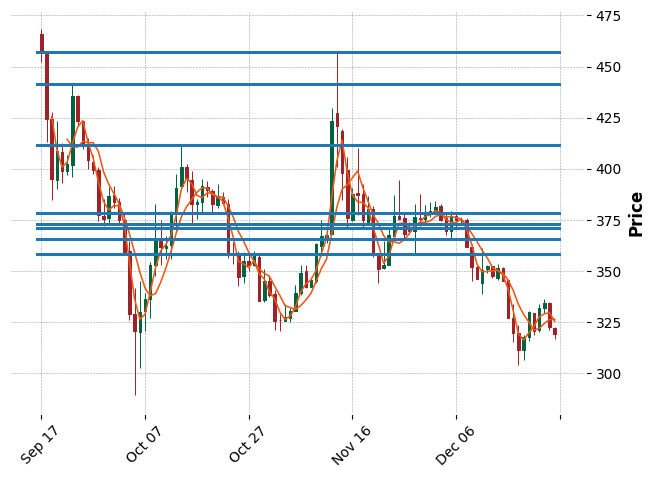

In [112]:
clean_levels = levels[abs(levels.diff() > 0)]
mpf.plot(df, type='candle', hlines=clean_levels.to_list(), style='charles', mav=(3, 6))

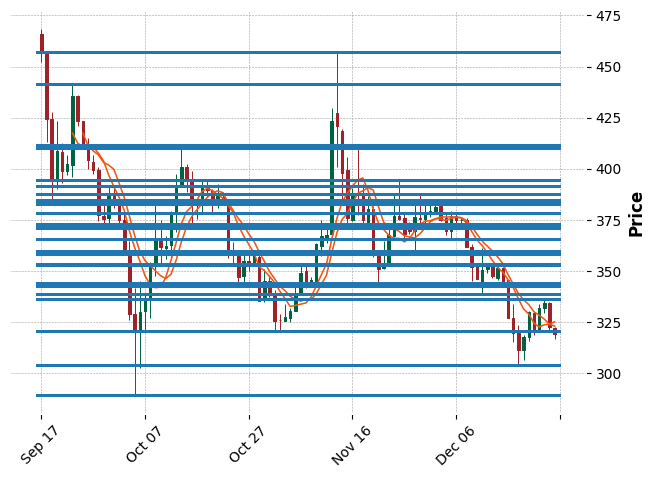

In [102]:
mpf.plot(df, type='candle', hlines=levels.to_list(), style='charles', mav=(7, 9))

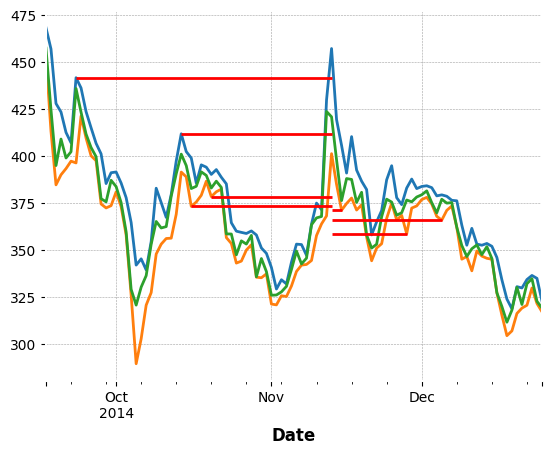

In [113]:
# MATPLOTLIB
clean_levels = levels[abs(levels.diff() > 0)]
df.High.plot()
df.Low.plot()
df.Close.plot()
plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')

In [131]:
# Supports and resistance line connected only between 2 points
support_points = supports.sort_values(ascending=False).head(2)
resistance_points = resistances.sort_values(ascending=False).head(2)
resistance_points

Date
2014-11-13    457.092987
2014-09-23    441.557007
2014-10-14    411.697998
2014-11-17    410.199005
2014-11-25    394.700989
2014-10-01    391.378998
2014-11-29    387.601013
2014-12-02    384.037994
2014-10-09    382.726013
2014-10-28    359.984009
2014-12-14    353.316010
2014-11-06    352.966003
2014-12-23    336.286987
Name: High, dtype: float64

In [130]:
# with indicator

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=[450]*len(df), line=dict(color='red', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=support_points, line=dict(color='green', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=resistances, mode="markers", marker=dict(size=5, color="MediumPurple"), name="Sell"),
                                    go.Scatter(x=df.index, y=supports, mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()